## Use Resnet18 to train on CIFAR-10

### CIFAR-10
- Consists of 32x32 colour images in 10 classes
- 50000 training images + 10000 test images

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torchvision import models
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Image normalization : 
#### 1. min/max normalization: 縮到 0-1 或 -1-1 之間，通常是 input range 已知的情況可用，output = input / 255 <br>
$x_{scaled}=\frac {x-x_{min}} {x_{max}-x_{min}}$
- transforms.ToTensor(): range(0, 255) -> range(0.0, 1.0)  

#### 2. Standardization: 將 sampled dataset 的 mean 和 std 轉換成接近於 0 和 1，以此減少偏差，避免被某部分資料支配，通常是用在 Input range 未知的情況，以採樣的方式來取得。
- mean -> 0 ：unbiased的data更有利於model學習
- std -> 1 ：減緩梯度消失和梯度爆炸

In [3]:
# 計算normalization需要的 mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)

print(train_mean, train_std)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
[0.49211264 0.48351443 0.44780117] [0.24790427 0.24408253 0.26234666]


### Data augmentation
- 為了在 training 樣本固定的情況下，藉由不改變被辨識物件特性(例如 classification種類)，對 image 做一些改動，來讓 training data 更多元化
- 將圖片進行旋轉、調整大小、比例尺寸，或改變亮度色溫、翻轉、加入 Gaussian noise等處理

In [4]:
# 計算 Gaussian noise # 將noise取一個高斯分佈的值並疊加到原圖上，可增加顆粒感
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

### Data augmentation & normalization

In [21]:
data_statistics = ((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) # (mean ,std) in 3 channels
transform_train = transforms.Compose([
    # Data augmentation
    # transforms.RandomCrop(32, padding = 4, padding_mode= 'reflect'),
    transforms.RandomHorizontalFlip(),       # Flips the image w.r.t horizontal axis
    # transforms.RandomRotation((-7,7)),     # Rotates the image to a specified angel
    # transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), # Performs actions like zooms, change shear angles.
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
    # Data normalization
    transforms.ToTensor(),    # C * H * W -> [0,1]
    # [-1,1] -> standardization: (image - train_mean) / train_std
    transforms.Normalize(*data_statistics, inplace = True),  
    # transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
    # add Gaussian noise
    # AddGaussianNoise(0., 1.),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics, inplace = True)     
])

In [22]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# 檢查training dataset長怎麼樣 
print(train_dataset)
print("train_dataset length: ", len(train_dataset))
print("classes: ", train_dataset.classes)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))
               AddGaussianNoise(mean=0.0, std=1.0)
           )
train_dataset length:  50000
classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [16]:
# setting parameter
EPOCH = 200     
BATCH_SIZE = 150    
lr = 0.05        
device = torch.device("cuda")

In [23]:
# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000           # 取 5000張驗證集(0.1 of trainset)
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
print("train length: ", len(train_dataset))
print("val length: ", len(val_dataset))
print("test length: ", len(test_dataset))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成batch 
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train length:  45000
val length:  5000
test length:  10000


In [24]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride = 1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [25]:
net = ResNet(ResidualBlock, [2, 2, 2]).to(device)
summary(net, input_size=(3,32,32))
print (net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
    ResidualBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

## Learning rate and update strategy
- 訓練 model時，若採用固定的 learning rate，容易找到 local minima 而非 global minima
- Learning Rate Decay : 通常在訓練一定 epoch 後，會對學習率進行衰減，從而讓 model 收斂得更好，但不斷的縮小 learning rate 也有缺點(陷入saddle point)
- 所以也有人使用 Cyclical Learning Rates: 設定學習率的上下限後，讓學習率在一定範圍內衰降或增加，在遇到 saddle point 不會卡住

In [19]:
# learning rate schedule
def adjust_learning_rate(optim, epoch):
    for param_group in optimizer.param_groups:    # change the lr to what you define
        param_group['lr'] = lr

### ReduceLROnPlateau
- optimer : 指的是網絡的優化器
- mode (str) : 可選擇'min'或者'max'，min表示當監控量停止下降的時候，學習率將減小，max表示當監控量停止上升的時候，學習率將減小。默認值為'min'
- factor : 學習率每次降低多少，new_lr = old_lr * factor
- patience=10 : 容忍網路的性能不提升的次數，高於這個次數就降低學習率
- verbose（bool）: 如果為True，則為每次更新向stdout輸出一條消息。默認值：False
- threshold（float）: 測量新最佳值的閾值，僅關注重大變化。默認值：1e-4
- cooldown ： 減少lr後恢復正常操作之前要等待的時期數。默認值：0。
- min_lr : 學習率的下限
- eps : 適用於lr的最小衰減。如果新舊lr之間的差異小於eps，則忽略更新。默認值：1e-8。

### ResNet18
- 用 Deep residual Network 來處理 degradation，這樣做能在網路層加深後，正確率至少不會變的更差。

### Degradation
- 當深度逐漸增加，我們發現56層的神經網路反而比20層網路結果還差。這樣的結果並非來自於 overfitting 和 Vanishing gradient problem，而是因為深度增加連帶著使得 training error 增加所導致的退化問題，以至於深層的特徵丟失了淺層特徵的原始模樣。


In [ ]:
# 是否使用 pretrain model
# net = models.resnet18(pretrained = True).to(device) 

In [26]:
# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function 
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)   # momentum-SGD，採用L2正則化（權重衰減）
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in range(EPOCH):
        # train
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index)
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()

            # learning rate schedule
        if (epoch + 1) % 10 == 0:
            lr /= 2  
            adjust_learning_rate(optim, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])
        
        loss1 = sum1_loss / (i + 1)
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)
                        
                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()
                    
            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)
                        
            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()
                    
        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))


Epoch: 1
learning rate:  0.05
Train loss: 1.500 | Train acc: 0.444
Val loss: 1.264 | Val acc: 0.532

Epoch: 2
learning rate:  0.05
Train loss: 1.016 | Train acc: 0.634
Val loss: 1.045 | Val acc: 0.625

Epoch: 3
learning rate:  0.05
Train loss: 0.822 | Train acc: 0.709
Val loss: 1.070 | Val acc: 0.637

Epoch: 4
learning rate:  0.05
Train loss: 0.700 | Train acc: 0.756
Val loss: 1.019 | Val acc: 0.659

Epoch: 5
learning rate:  0.05
Train loss: 0.619 | Train acc: 0.785
Val loss: 0.818 | Val acc: 0.714

Epoch: 6
learning rate:  0.05
Train loss: 0.562 | Train acc: 0.804
Val loss: 0.724 | Val acc: 0.747

Epoch: 7
learning rate:  0.05
Train loss: 0.518 | Train acc: 0.820
Val loss: 0.835 | Val acc: 0.718

Epoch: 8
learning rate:  0.05
Train loss: 0.482 | Train acc: 0.833
Val loss: 0.672 | Val acc: 0.764

Epoch: 9
learning rate:  0.05
Train loss: 0.460 | Train acc: 0.839
Val loss: 0.611 | Val acc: 0.787

Epoch: 10
learning rate:  0.025
Train loss: 0.436 | Train acc: 0.848
Val loss: 0.762 | Val

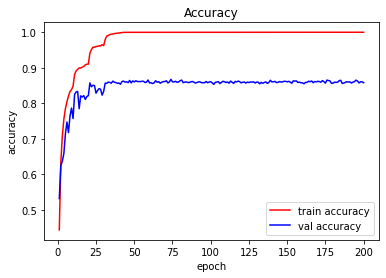

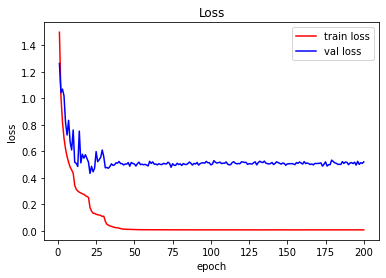

In [27]:
import matplotlib.pyplot as plt
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy") 
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss") 
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Reference

https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10